### 1. Evaluasi Model Klasifikasi

Dalam tahap evaluasi model, digunakan beberapa **metode pengukuran performa** untuk menilai seberapa baik model dalam memprediksi kelas target.

---

#### a. **Confusion Matrix**
Confusion Matrix menunjukkan **perbandingan antara hasil prediksi model dan nilai sebenarnya**.  
Tabel ini menampilkan jumlah:
- **True Positive (TP)** → Prediksi benar sebagai positif  
- **True Negative (TN)** → Prediksi benar sebagai negatif  
- **False Positive (FP)** → Prediksi salah sebagai positif  
- **False Negative (FN)** → Prediksi salah sebagai negatif  

Dari matriks ini, kita bisa memahami kesalahan model secara detail.

---

#### b. **Accuracy, Precision, Recall, dan F1-Score**
Beberapa metrik umum yang dihitung dari confusion matrix:
- **Accuracy** → Seberapa banyak prediksi yang benar dari seluruh data.  
- **Precision** → Dari semua prediksi positif, berapa yang benar-benar positif.  
- **Recall (Sensitivity)** → Dari semua data positif sebenarnya, berapa yang berhasil diprediksi dengan benar. 
- **F1-Score** → Rata-rata harmonik antara Precision dan Recall.  


---

#### c. **ROC Curve dan AUC (Area Under Curve)**
ROC Curve digunakan untuk **menilai kemampuan model membedakan antara kelas positif dan negatif**.

- Sumbu **X**: False Positive Rate (FPR)  
- Sumbu **Y**: True Positive Rate (TPR / Recall)  
- Semakin mendekati sudut kiri atas, semakin baik performa model.  
- Nilai **AUC** (Area Under Curve) mengukur luas area di bawah kurva:
  - AUC = 1 → Model sempurna  
  - AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan)

---



In [1]:
%matplotlib inline
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc
)
from sklearn.model_selection import train_test_split

# Config - adjust filenames if you used different names
PREPROCESSED_CSV = 'student_preprocessed.csv'
TREE_MODEL = 'decision_tree.joblib'
SVM_MODEL = 'svm_model.joblib'

# Safety checks
for f in [PREPROCESSED_CSV, TREE_MODEL, SVM_MODEL]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"{f} not found — run preprocessing & training scripts first.")

2. Load dataset dan split (random_state/stratify)

In [2]:
df = pd.read_csv(PREPROCESSED_CSV)
if 'pass' not in df.columns:
    raise ValueError("Expected 'pass' column in preprocessed CSV")

X = df.drop(columns=['pass'])
y = df['pass']

# Use the same split ratio and RNG seed you used during training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes — X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes — X_test: (130, 56) y_test: (130,)


3. Load model yang sudah dilatih

In [3]:
tree = joblib.load(TREE_MODEL)
svm = joblib.load(SVM_MODEL)

# Predict
y_pred_tree = tree.predict(X_test)
y_pred_svm = svm.predict(X_test)

# Basic metrics function
def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"--- {name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print()
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print("\n")

# Print metrics
print_metrics("Decision Tree", y_test, y_pred_tree)
print_metrics("SVM", y_test, y_pred_svm)

--- Decision Tree ---
Accuracy:  0.7692
Precision: 0.8509
Recall:    0.8818
F1-score:  0.8661

Classification report:
              precision    recall  f1-score   support

           0     0.1875    0.1500    0.1667        20
           1     0.8509    0.8818    0.8661       110

    accuracy                         0.7692       130
   macro avg     0.5192    0.5159    0.5164       130
weighted avg     0.7488    0.7692    0.7585       130



--- SVM ---
Accuracy:  0.8308
Precision: 0.8607
Recall:    0.9545
F1-score:  0.9052

Classification report:
              precision    recall  f1-score   support

           0     0.3750    0.1500    0.2143        20
           1     0.8607    0.9545    0.9052       110

    accuracy                         0.8308       130
   macro avg     0.6178    0.5523    0.5597       130
weighted avg     0.7859    0.8308    0.7989       130





4. Confusion Matrix dan SVM

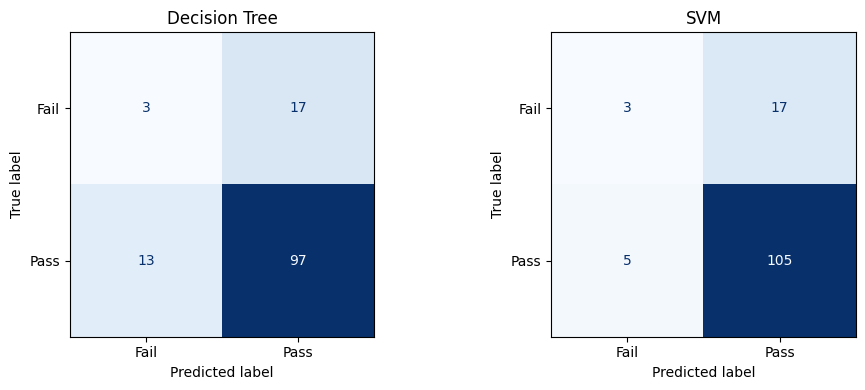

In [4]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Fail','Pass'])
disp_tree.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title('Decision Tree')

plt.subplot(1,2,2)
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Fail','Pass'])
disp_svm.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title('SVM')

plt.tight_layout()
plt.show()


5. ROC curve untuk setiap model

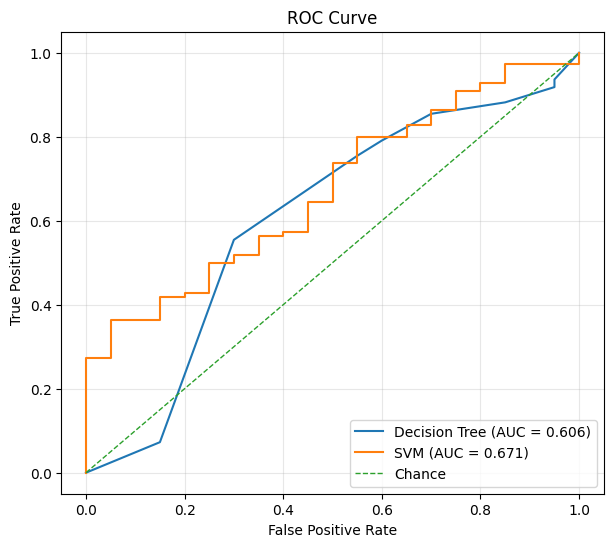

In [5]:
plt.figure(figsize=(7,6))

models_info = [
    ("Decision Tree", tree),
    ("SVM", svm)
]

any_roc = False
for name, model in models_info:
    # Try to get scores for ROC: prefer predict_proba[:,1], fallback to decision_function
    y_score = None
    if hasattr(model, "predict_proba"):
        try:
            y_score = model.predict_proba(X_test)[:, 1]
        except Exception:
            y_score = None
    if y_score is None and hasattr(model, "decision_function"):
        try:
            y_score = model.decision_function(X_test)
            # decision_function may need scaling for AUC calculation — it's fine to use raw outputs
        except Exception:
            y_score = None

    if y_score is None:
        print(f"Skipping ROC for {name}: model has no predict_proba or decision_function available.")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_score)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {model_auc:.3f})")
    any_roc = True

# Random-chance baseline
plt.plot([0,1], [0,1], linestyle='--', linewidth=1, label='Chance')

if any_roc:
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No ROC curves were produced (no model provided probabilities or decision function).")
